In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

train_path = 'train_new.csv'
train_data = pd.read_csv(train_path)

In [8]:
from autosklearn.regression import AutoSklearnRegressor

In [9]:
print(train_data.head())

                ID District      Block  CultLand  CropCultLand  \
0  ID_GTFAC7PEVWQ9  Nalanda  Noorsarai        45            40   
1  ID_TK40ARLSPOKS  Nalanda     Rajgir        26            26   
2  ID_1FJY2CRIMLZZ     Gaya      Gurua        10            10   
3  ID_I3IPXS4DB7NE     Gaya      Gurua        15            15   
4  ID_4T8YQWXWHB4A  Nalanda  Noorsarai        60            60   

                               LandPreparationMethod CropTillageDate  \
0               TractorPlough FourWheelTracRotavator      2022-07-20   
1  WetTillagePuddling TractorPlough FourWheelTrac...      2022-07-18   
2               TractorPlough FourWheelTracRotavator      2022-06-30   
3               TractorPlough FourWheelTracRotavator      2022-06-16   
4                   TractorPlough WetTillagePuddling      2022-07-19   

   CropTillageDepth         CropEstMethod RcNursEstDate  ... Harv_method  \
0                 5  Manual_PuddledRandom    2022-06-27  ...     machine   
1                 

A very simple preprocessing method to test if AutoML tools are able to figure out the best model with a non-optimal preprocessing.

In [10]:
# Convert datetime columns to datetime format and extract year, month, day, try to use this simple preprocessing method first
datetime_cols = ['CropTillageDate', 'RcNursEstDate', 'Harv_date', 'Threshing_date']
for col in datetime_cols:
    train_data[col] = pd.to_datetime(train_data[col])
    train_data[col + '_year'] = train_data[col].dt.year
    train_data[col + '_month'] = train_data[col].dt.month
    train_data[col + '_day'] = train_data[col].dt.day

# Drop original datetime columns, only use new columns
train_data.drop(columns=datetime_cols, inplace=True)

# Encode categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le


# Preparing the data for modeling
# Training Features
X = train_data.drop(['ID', 'Yield'], axis=1) 
# Target Feature
y = train_data['Yield']  

# Splitting the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fit AutoML pipeline on the train datasets.

In [13]:
import autosklearn
automl = AutoSklearnRegressor(time_left_for_this_task=3600, 
                              per_run_time_limit=360, 
                              n_jobs=-1, memory_limit=30000, 
                              metric=autosklearn.metrics.mean_squared_error,
                              ensemble_kwargs={"ensemble_size": 3} 
)
automl.fit(X_train, y_train)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     ensemble_kwargs={'ensemble_size': 3}, memory_limit=30000,
                     metric=mean_squared_error, n_jobs=-1,
                     per_run_time_limit=360)

Predict on the test dataset.

In [18]:
y_pred= automl.predict(X_test)

# use the pre-defined score function to evaluate the model
automl.score(y_test, y_pred)

ValueError: Auto-sklearn only supports Numpy arrays, Pandas DataFrames, scipy sparse and Python Lists, yet, the provided input is of type <class 'pandas.core.series.Series'>

Show statistical analysis results.

This function will show the following result to the user:

-dataset name

-metric used

-best validation score

-number of target algorithm runs

-number of successful target algorithm runs

-number of crashed target algorithm runs

-number of target algorithm runs that exceeded the memory limit

-number of target algorithm runs that exceeded the time limit

In [15]:
sprint_statistics_str = automl.sprint_statistics()
print(sprint_statistics_str)

auto-sklearn results:
  Dataset name: c53a439b-dc70-11ee-9373-83a9c127745e
  Metric: mean_squared_error
  Best validation score: 17924.973567
  Number of target algorithm runs: 779
  Number of successful target algorithm runs: 584
  Number of crashed target algorithm runs: 68
  Number of target algorithms that exceeded the time limit: 118
  Number of target algorithms that exceeded the memory limit: 9



Check the model leaderboard

In [16]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
637,1,0.333333,extra_trees,17924.973567,57.075341
467,2,0.333333,extra_trees,18288.758278,37.780268
616,3,0.333333,gaussian_process,20343.860931,214.541546


check the cross validation results.

In [17]:
print(automl.cv_results_)

{'mean_test_score': array([2.02931847e+04, 2.14748365e+09, 2.14748365e+09, 3.06689749e+04,
       4.70674442e+04, 2.14748365e+09, 2.50644252e+04, 2.14748365e+09,
       1.94722644e+04, 3.25351100e+04, 7.08833172e+04, 6.29296671e+04,
       2.14748365e+09, 2.14748365e+09, 2.14748365e+09, 1.25561339e+05,
       2.14748365e+09, 2.14748365e+09, 2.14748365e+09, 2.14748365e+09,
       3.24676907e+04, 2.49324960e+04, 2.40484648e+04, 2.28287133e+04,
       1.55725458e+05, 3.31665057e+04, 3.40018993e+04, 3.11855374e+04,
       5.77315536e+04, 1.96862278e+05, 4.47678504e+04, 2.14748365e+09,
       5.38523708e+04, 2.14748365e+09, 2.14748365e+09, 3.15274391e+04,
       2.14748365e+09, 2.14748365e+09, 3.46030224e+07, 1.92547514e+05,
       8.42360188e+04, 2.31686470e+04, 3.42663547e+04, 5.25784155e+04,
       1.36247264e+05, 2.79256598e+04, 4.37620424e+04, 2.14748365e+09,
       2.14748365e+09, 2.42840500e+04, 6.55407274e+04, 3.68628143e+04,
       2.84477346e+04, 2.14748365e+09, 2.37910459e+04, 2.

However, the mean_sqaured_error still shows a huge gap with the normal methods without AutoML

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

132.74205892532873


Check the permutation importance of the model parameters

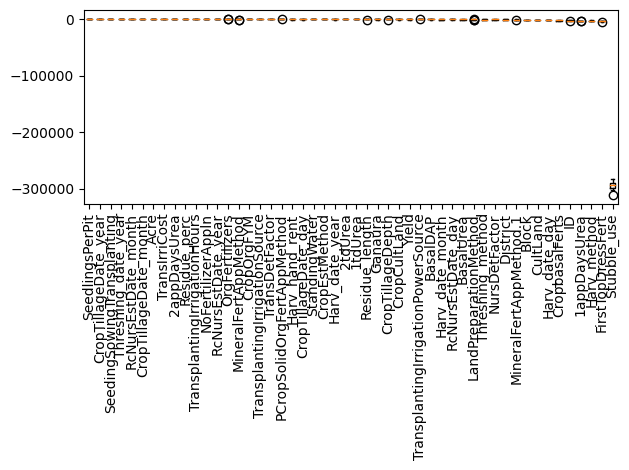

MineralFertAppMethod.1: -692.810 +/- 333.835
Block     : -755.894 +/- 97.270
CultLand  : -860.909 +/- 160.272
Harv_date_day: -993.639 +/- 194.794
CropbasalFerts: -2034.808 +/- 319.218
ID        : -2518.884 +/- 498.681
1appDaysUrea: -2617.097 +/- 149.526
Harv_method: -2909.892 +/- 695.899
FirstTopDressFert: -3613.870 +/- 437.847


In [23]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[train_data.columns[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[-10:-1]:
    print(
        f"{train_data.columns[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

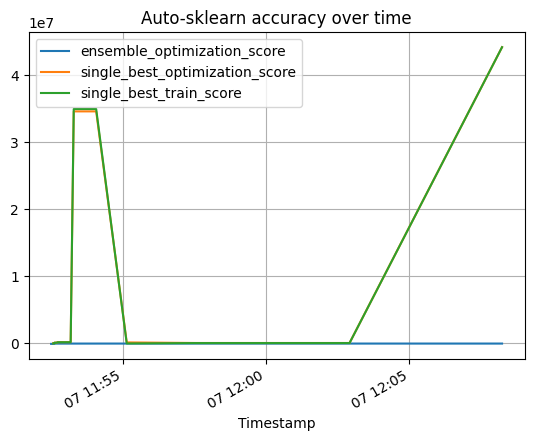

In [21]:
poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [22]:
from pprint import pprint

pprint(automl.show_models(), indent=4)

{   467: {   'cost': 18288.758278331432,
             'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa4db7428b0>,
             'ensemble_weight': 0.3333333333333333,
             'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fa4f60ce4c0>,
             'model_id': 467,
             'rank': 1,
             'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7fa5de5431c0>,
             'sklearn_regressor': ExtraTreesRegressor(criterion='mae', max_features=0.8676682909536549,
                    n_estimators=512, n_jobs=1, random_state=1,
                    warm_start=True)},
    616: {   'cost': 20343.860930826966,
             'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa62a9c14c0>,
             'ensemble_weight': 0.3333333333333333,
             'feature_p